# LDA - Linear Discriminant Analysis

Linear Discriminant Analysis is a dimensionality reduction technique which reduces dimensions based on a supervised algorithm. The algorithm reduces number of features/variables based on predefined class/labels present in the dataset. It selects the derived features in such a manner that the classes present in data are easily distinguishable.


Theory: http://www.sci.utah.edu/~shireen/pdfs/tutorials/Elhabian_LDA09.pdf



We'll be using iris dataset for this example.


In [2]:
#reading the dataset

import pandas as pd

df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )

In [3]:
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
#creating feature names list
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}


In [5]:
print(feature_dict)

{0: 'sepal length in cm', 1: 'sepal width in cm', 2: 'petal length in cm', 3: 'petal width in cm'}


In [6]:
#changing column names
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
#removing nulls
df.dropna(how="all", inplace=True) # to drop the empty line at file-end
#printing sample
df.tail()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [7]:
#Checking dataset for possible labels
df['class label'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [26]:
#changing labels into numeric from categorical. its easier to deal with numeric labels
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:,0:4].values
y = df['class label'].values

enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

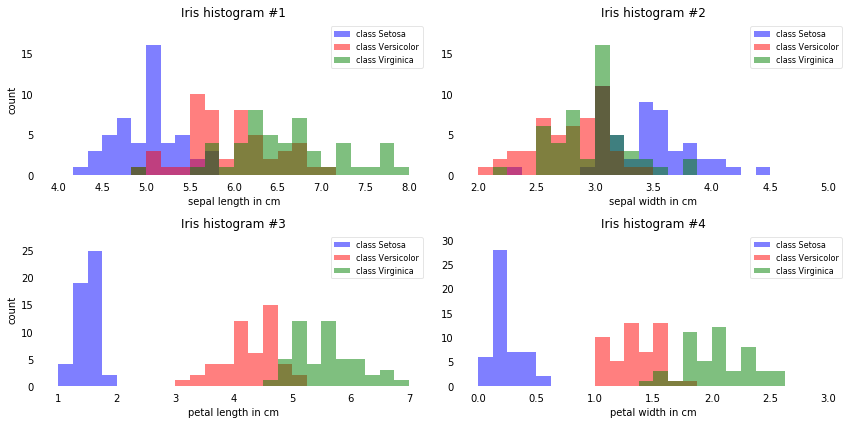

In [27]:
#performing eda - plotting histograms of label wrt 4 features
from matplotlib import pyplot as plt
import numpy as np
import math
get_ipython().magic(u'matplotlib inline')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt])) #floor of min value in column
    max_b = math.ceil(np.max(X[:,cnt]))  #ceiling of max value in column
    bins = np.linspace(min_b, max_b, 25) #bins = min, min + (max - min)/25 , min + 2*(max - min)/25, ........

    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       

plt.show()

## Step wise LDA

### Step 1 - Computing d-dimensional mean vectors

In [28]:
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [5.006 3.418 1.464 0.244]

Mean Vector class 2: [5.936 2.77  4.26  1.326]

Mean Vector class 3: [6.588 2.974 5.552 2.026]



### Step 2 - Computing the scatter matrices

#### 2.1 Within class scatter matrix

In [29]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix: \n', S_W)

within-class Scatter Matrix: 
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


#### 2.2 Between class scatter matrix

In [30]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  #enumerate just adds a number from 0 to every value in object
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)


between-class Scatter Matrix:
 [[ 63.2121 -19.534  165.1647  71.3631]
 [-19.534   10.9776 -56.0552 -22.4924]
 [165.1647 -56.0552 436.6437 186.9081]
 [ 71.3631 -22.4924 186.9081  80.6041]]


### Step 3 - Solving the generalized eigenvalue problem for the matrix S−1WSB

In [31]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B)) #makes eigenvector from matrix

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[-0.2049]
 [-0.3871]
 [ 0.5465]
 [ 0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[-0.8844]
 [ 0.2854]
 [ 0.258 ]
 [ 0.2643]]
Eigenvalue 3: 3.42e-15

Eigenvector 4: 
[[-0.2234]
 [-0.2523]
 [-0.326 ]
 [ 0.8833]]
Eigenvalue 4: 1.15e-14


In [32]:
#Checking the eigenvector-eigenvalue calculation
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                         eig_vals[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)
print('ok')

ok


#### 4.1 Ordering eigenvectors by decreasing order of eigenvalue

In [34]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

In [35]:
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

In [36]:
# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.27195779972981
0.27756686384003953
1.1483362279322388e-14
3.422458920849769e-15


In [37]:
#Representing values in %
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


#### 4.2 Choosing k eigenvectors with the largest eigenvalues

Here only 2 are adding information, hence selecting only first 2. We can also exclude the second one as the value add is too low.

In [38]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1))) #cbind 2 arrays
print('Matrix W:\n', W.real)

Matrix W:
 [[-0.2049 -0.009 ]
 [-0.3871 -0.589 ]
 [ 0.5465  0.2543]
 [ 0.7138 -0.767 ]]


### Step 5 - Transforming the samples onto the new subspace

In [40]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional." #Error debugger. If condition is true, does nothing, 
#else gives error message

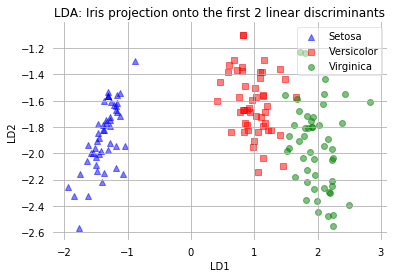

In [41]:
def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

## Comparison with PCA

C:\Users\Samrat Vij\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


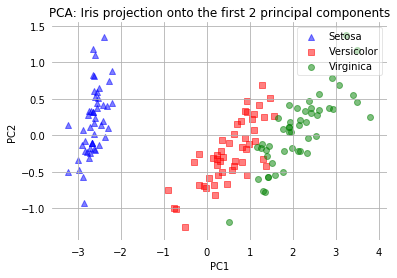

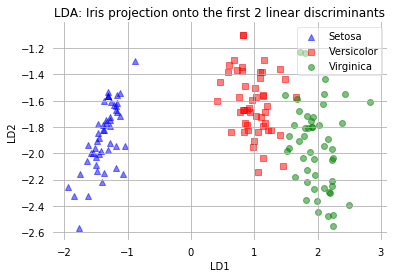

In [42]:
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=2)
X_pca = sklearn_pca.fit_transform(X)

def plot_pca():

    ax = plt.subplot(111)

    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_pca[:,0][y == label],
                y=X_pca[:,1][y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('PC1')
    plt.ylabel('PC2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('PCA: Iris projection onto the first 2 principal components')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.tight_layout
    plt.grid()

    plt.show()
plot_pca()
plot_step_lda()

## LDA Using scikit learn

In [43]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA
sklearn_lda = LDA(n_components=2)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

In [44]:
def plot_scikit_lda(X, title):

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label] * -1, # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

C:\Users\Samrat Vij\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


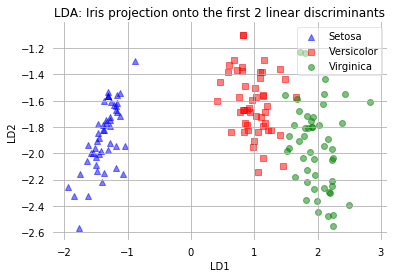

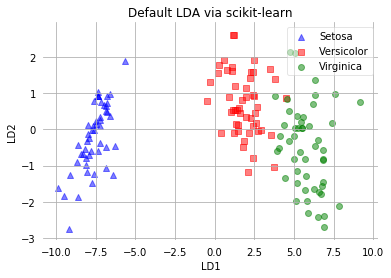

In [45]:
plot_step_lda()
plot_scikit_lda(X_lda_sklearn, title='Default LDA via scikit-learn')